In [5]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.stats import fisher_exact
from matplotlib.patches import Patch
from matplotlib.container import BarContainer

In [6]:
CUTOFF   = 1
SYN_ONLY = True
SPECIES_ORDER = ["F. graminearum", "N. crassa", "N. tetrasperma", "S. cerevisiae", "S. pombe"]

FG_FASTA = "../genomic_data/fgraminearum/fg_canonical_cds.fasta"
NC_FASTA = "../genomic_data/ncrassa/nc_canonical_cds.fasta"
NT_FASTA = "../genomic_data/ntetrasperma/nt_canonical_cds.fasta"
SC_FASTA = "../genomic_data/scerevisiae/sc_canonical_cds.fasta"
SP_FASTA = "../genomic_data/spombe/sp_canonical_cds.fasta"

FG_EXPR  = "../expr_and_motif_avoid/fgraminearum_gene_counts.tsv"
NC_EXPR  = "../expr_and_motif_avoid/ncrassa_gene_counts.tsv"
NT_EXPR  = "../expr_and_motif_avoid/ntetrapserma_gene_counts.tsv"
SC_EXPR  = "../expr_and_motif_avoid/scerevisiae_gene_counts.tsv"
SP_EXPR  = "../expr_and_motif_avoid/spombe_gene_counts.tsv"

FG_SEX_COLS = ["Sex8d_1_quant","Sex8d_2_quant"]
NC_SEX_COLS = ["P6_1_quant","P6_2_quant"]
NT_SEX_COLS = ["P6_1_quant"]
SC_SEX_COLS = ["meiotic_1_quant","meiotic_2_quant"]
SP_SEX_COLS = ["meiotic_1_quant","meiotic_2_quant"]

syn_sets = {
    'A': ['GCT','GCC','GCA','GCG'], 'C': ['TGT','TGC'], 'D': ['GAT','GAC'],
    'E': ['GAA','GAG'], 'F': ['TTT','TTC'], 'G': ['GGT','GGC','GGA','GGG'],
    'H': ['CAT','CAC'], 'I': ['ATT','ATC','ATA'], 'K': ['AAA','AAG'],
    'L': ['TTA','TTG','CTT','CTC','CTA','CTG'], 'M': ['ATG'],
    'N': ['AAT','AAC'], 'P': ['CCT','CCC','CCA','CCG'], 'Q': ['CAA','CAG'],
    'R': ['CGT','CGC','CGA','CGG','AGA','AGG'], 'S': ['TCT','TCC','TCA','TCG','AGT','AGC'],
    'T': ['ACT','ACC','ACA','ACG'], 'V': ['GTT','GTC','GTA','GTG'],
    'W': ['TGG'], 'Y': ['TAT','TAC'], '*': ['TAA','TAG','TGA']
}
CODON_TO_AA = {c: aa for aa, cs in syn_sets.items() for c in cs}

def build_synonymous_eligibility(base: str) -> set:
    """Return AAs where 3rd-bases can be 'base' or 'non-base' without AA change."""
    eligible = set()
    for aa, codons in syn_sets.items():
        if aa in {"M", "W", "*"}:
            continue
        has_base    = any(c.endswith(base) for c in codons)
        has_nonbase = any(not c.endswith(base) for c in codons)
        if has_base and has_nonbase:
            eligible.add(aa)
    return eligible

ELIGIBLE = {b: build_synonymous_eligibility(b) for b in ["A","T","C","G"]}

def read_fasta(path: str) -> dict:
    seqs = {}
    with open(path) as f:
        gid, buf = None, []
        for line in f:
            if line.startswith(">"):
                if gid:
                    seqs[gid] = "".join(buf).upper()
                hdr = line[1:].strip()
                m = re.search(r'\[locus_tag=([^\]]+)\]', hdr)
                gid = m.group(1) if m else hdr.split()[0].replace("lcl|", "")
                buf = []
            else:
                buf.append(line.strip())
        if gid:
            seqs[gid] = "".join(buf).upper()
    return seqs

def codonize(seqs: dict) -> dict:
    return {g: [seq[i:i+3] for i in range(0, len(seq) - (len(seq)%3), 3)]
            for g, seq in seqs.items()}

def build_sets_S_NotS(expr: pd.DataFrame, sex_cols: list[str],cutoff=1):
    """
    Classify genes based on expression in sex samples only.
    - S: expressed (any sex sample >= 1)
    - NotS: not expressed (all sex samples < 1)
    """
    S_mask = expr[sex_cols].ge(cutoff).any(axis=1)
    S = set(expr.loc[S_mask, "Name"])
    NotS = set(expr.loc[~S_mask, "Name"])
    return {"S": S, "NotS": NotS}

fg_expr = pd.read_csv(FG_EXPR, sep="\t")
nc_expr = pd.read_csv(NC_EXPR, sep="\t")
nt_expr = pd.read_csv(NT_EXPR, sep="\t")
sc_expr = pd.read_csv(SC_EXPR, sep="\t")
sp_expr = pd.read_csv(SP_EXPR, sep="\t")

SPECIES = {
    "Fg": {"label": "F. graminearum", "fasta": FG_FASTA, "expr": fg_expr, "sex_cols": FG_SEX_COLS},
    "Nc": {"label": "N. crassa",      "fasta": NC_FASTA, "expr": nc_expr, "sex_cols": NC_SEX_COLS},
    "Nt": {"label": "N. tetrasperma",      "fasta": NT_FASTA, "expr": nt_expr, "sex_cols": NT_SEX_COLS},
    "Sc": {"label": "S. cerevisiae",  "fasta": SC_FASTA, "expr": sc_expr, "sex_cols": SC_SEX_COLS},
    "Sp": {"label": "S. pombe",       "fasta": SP_FASTA, "expr": sp_expr, "sex_cols": SP_SEX_COLS},
}
for cfg in SPECIES.values():
    cfg["seqs"]   = read_fasta(cfg["fasta"])
    cfg["codons"] = codonize(cfg["seqs"])
    cfg["sets"]   = build_sets_S_NotS(cfg["expr"], cfg["sex_cols"], CUTOFF)

In [7]:
def count_boundary_TA_fraction(codon_dict, gene_ids, syn_only=True):
    """
    Returns: (T_before_A, Astart_total)
    """
    T_before_A = 0
    Astart_total = 0
    for gid in (gene_ids & codon_dict.keys()):
        cods = codon_dict[gid]
        for i in range(len(cods)-1):
            c0, c1 = cods[i], cods[i+1]
            aa0 = CODON_TO_AA.get(c0)
            if aa0 is None or aa0 == "*":
                continue
            if syn_only and aa0 not in ELIGIBLE["T"]:
                continue
            if c1[0] == "A":
                Astart_total += 1
                if c0[2] == "T":
                    T_before_A += 1
    return T_before_A, Astart_total

def fisher_S_vs_NotS_boundary(S_cnt, S_tot, N_cnt, N_tot):
    if S_tot and N_tot:
        table = [[S_cnt, S_tot - S_cnt],
                 [N_cnt, N_tot - N_cnt]]
        OR, p_two = fisher_exact(table, alternative="two-sided")
        return OR, p_two, table
    return np.nan, np.nan, [[0,0],[0,0]]

rows_boundary = []
for code, cfg in SPECIES.items():
    S_ids, NotS_ids = cfg["sets"]["S"], cfg["sets"]["NotS"]

    s_TA, s_A = count_boundary_TA_fraction(cfg["codons"], S_ids, syn_only=SYN_ONLY)
    n_TA, n_A = count_boundary_TA_fraction(cfg["codons"], NotS_ids, syn_only=SYN_ONLY)

    OR, p2, tab = fisher_S_vs_NotS_boundary(s_TA, s_A, n_TA, n_A)

    rows_boundary += [
        {"species": cfg["label"], "stage": "S",
         "fraction_T_given_Astart": (s_TA / s_A) if s_A else np.nan,
         "T_before_A": s_TA, "Astart_total": s_A,
         "OR_SvsNotS": OR, "p_two": p2},
        {"species": cfg["label"], "stage": "NotS",
         "fraction_T_given_Astart": (n_TA / n_A) if n_A else np.nan,
         "T_before_A": n_TA, "Astart_total": n_A,
         "OR_SvsNotS": OR, "p_two": p2},
    ]

df_boundary = pd.DataFrame(rows_boundary)

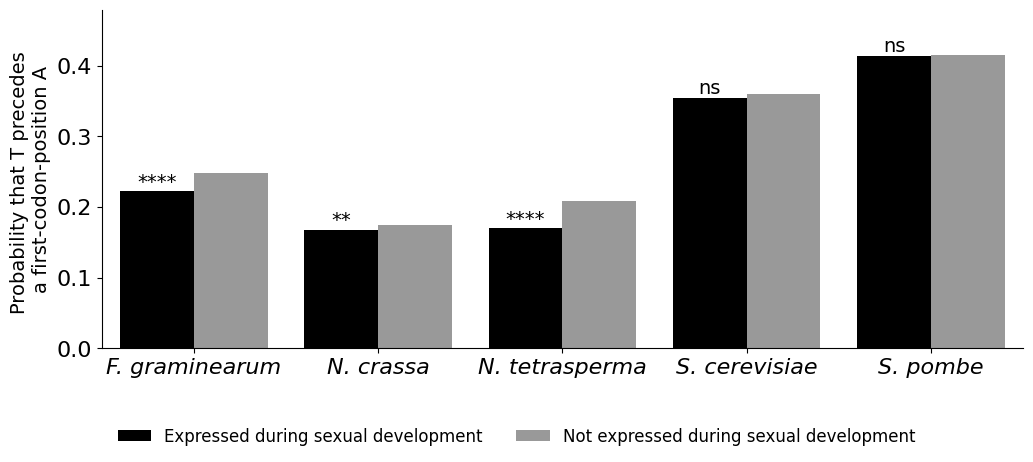

In [8]:
palette = {"S": "black", "NotS": "0.6"}

g = sns.catplot(
    data=df_boundary,
    x="species",
    y="fraction_T_given_Astart",
    hue="stage",
    hue_order=["S","NotS"],
    kind="bar",
    order=SPECIES_ORDER,
    height=4.8,
    aspect=2.0,
    palette=palette,
    sharey=True
)

if getattr(g, "_legend", None) is not None:
    g._legend.remove()

legend_handles = [
    Patch(facecolor="black", label="Expressed during sexual development"),
    Patch(facecolor="0.6",   label="Not expressed during sexual development"),
]

def _stars(p):
    if p is None or not np.isfinite(p): return "ns"
    return "****" if p < 1e-4 else "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 0.05 else "ns"

pmap = (df_boundary.query("stage == 'S'")
                  .set_index("species")["p_two"]
                  .to_dict())

for ax in g.axes.flat:
    containers = [c for c in ax.containers if isinstance(c, BarContainer)]
    if not containers:
        continue
    s_container = containers[0]
    labels = [_stars(pmap.get(sp)) for sp in SPECIES_ORDER]
    ymin, ymax = ax.get_ylim()
    pad = 0.015 * (ymax - ymin)
    ax.bar_label(s_container, labels=labels, padding=int(pad), fontsize=14, clip_on=False)
    ax.set_ylim(ymin, ymax + 0.10*(ymax - ymin))

for ax in g.axes.flat:
    ax.set_xlabel("")
    ax.set_ylabel("Probability that T precedes \na first-codon-position A", fontsize=14)
    for lbl in ax.get_xticklabels():
        lbl.set_fontstyle("italic")
        lbl.set_fontsize(16)
    ax.tick_params(axis="y", labelsize=16)


plt.tight_layout(rect=[0, 0.12, 1, 0.95])

g.fig.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.02),
    ncol=2,
    frameon=False,
    title="",
    fontsize=12
)

plt.show()

In [9]:
wide = (
    df_boundary
    .pivot(index="species", columns="stage", values=["T_before_A", "Astart_total"])
)

wide.columns = ["_".join(col) for col in wide.columns]

# compute frequencies from counts of each TA motif
wide["f_S"] = wide["T_before_A_S"] / wide["Astart_total_S"]
wide["f_NotS"] = wide["T_before_A_NotS"] / wide["Astart_total_NotS"]

wide["delta"] = wide["f_NotS"] - wide["f_S"]
wide["depletion_pct"] = 100 * wide["delta"] / wide["f_NotS"]

wide.reset_index()

,species,T_before_A_NotS,T_before_A_S,Astart_total_NotS,Astart_total_S,f_S,f_NotS,delta,depletion_pct
0,F. graminearum,38194,265883,153674,1197389,0.222052,0.248539,0.026487,10.656994
1,N. crassa,5506,167832,31583,1000684,0.167717,0.174334,0.006617,3.795588
2,N. tetrasperma,12201,162037,58581,953383,0.169960,0.208276,0.038316,18.396621
3,S. cerevisiae,10404,258913,28888,730121,0.354617,0.360150,0.005533,1.536301
4,S. pombe,110934,115120,267339,277843,0.414335,0.414956,0.000622,0.149793


In [10]:
def count_TA_classes(codon_dict, gene_ids):
    XTA = TAX = XXTA = 0

    for gid in (set(gene_ids) & set(codon_dict.keys())):
        cods = codon_dict[gid]
        m = sum(1 for c in cods if len(c) == 3)
        if m == 0:
            continue

        for i, c in enumerate(cods[:m]):
            if c[0] == "T" and c[1] == "A":
                XTA += 1
            if c[1] == "T" and c[2] == "A":
                TAX += 1
            if i < m - 1:
                c_next = cods[i+1]
                if c[2] == "T" and c_next[0] == "A":
                    XXTA += 1

    total = XTA + TAX + XXTA
    return {"XTA": XTA, "TAX": TAX, "XXTA": XXTA, "TA_total": total}


weights = []
for code, cfg in SPECIES.items():
    NotS_ids = cfg["sets"]["NotS"]
    cntN = count_TA_classes(cfg["codons"], NotS_ids)

    w = cntN["XXTA"] / cntN["TA_total"] if cntN["TA_total"] else np.nan

    weights.append({
        "species": cfg["label"],
        "XTA_NotS": cntN["XTA"],
        "TAX_NotS": cntN["TAX"],
        "XXTA_NotS": cntN["XXTA"],
        "TA_total_NotS": cntN["TA_total"],
        "weight_XXTA_in_all_TA": w
    })

df_weight = pd.DataFrame(weights)
df_weight

,species,XTA_NotS,TAX_NotS,XXTA_NotS,TA_total_NotS,weight_XXTA_in_all_TA
0,F. graminearum,23180,22476,38194,83850,0.455504
1,N. crassa,4035,3457,5506,12998,0.423604
2,N. tetrasperma,7924,8087,12201,28212,0.432476
3,S. cerevisiae,4283,7199,10404,21886,0.475372
4,S. pombe,41584,74707,110934,227225,0.488212


In [11]:
wide2 = wide.reset_index()[["species", "depletion_pct"]]

df_out = (
    df_weight[["species", "weight_XXTA_in_all_TA"]]
    .merge(wide2, on="species", how="inner")
)

df_out["estimated_total_TA_drop_pct"] = (
    df_out["weight_XXTA_in_all_TA"] * df_out["depletion_pct"]
)

df_out

,species,weight_XXTA_in_all_TA,depletion_pct,estimated_total_TA_drop_pct
0,F. graminearum,0.455504,10.656994,4.854302
1,N. crassa,0.423604,3.795588,1.607825
2,N. tetrasperma,0.432476,18.396621,7.956088
3,S. cerevisiae,0.475372,1.536301,0.730315
4,S. pombe,0.488212,0.149793,0.073131
